In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import time
import msgpack
import mignn
from mignn.dataset import PathLightDataset
from torch_geometric.data import Data
import torch
from itertools import chain

In [2]:
import tqdm
from multiprocessing.pool import ThreadPool

In [3]:
WIDTH, HEIGHT = 100, 100

In [4]:
base_folder = "../build"

## Paralleled process

In [18]:
done = 1
to_load = 16
def load_data_msgpack(filename):
    #global done
    c_data = {}
    with open(filename, 'rb') as f:
        data = msgpack.unpackb(f.read(), raw=False)
        for k_pixel in data.keys():
            h, w = list(map(int, k_pixel.split(',')))
            c_data[(h, w)] = data[k_pixel]['y']
    #done = done + 1
    return c_data

def load_and_convert(filename, output_folder):
    #global done
    _, outfile = os.path.split(filename)
    graphs = []
    with open(filename, 'rb') as f:
        data = msgpack.unpackb(f.read(), raw=False)
        
        # for each key data, extract graph
        for key, k_data in data.items():
            
            pixel = list(map(int, key.split(',')))
            x_node = torch.tensor(k_data["x"], dtype=torch.float)
            y = torch.tensor(k_data["y"], dtype=torch.float)
            edge_index = torch.tensor(k_data["edge_index"], dtype=torch.long)    
            edge_attr = torch.tensor(k_data["edge_attr"], dtype=torch.float)
            
            graph_data = Data(x=x_node, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr, y=y, key=pixel)
            graphs.append(graph_data)
    
    output_dataset = os.path.join(output_folder, outfile.split('.')[0])
    os.makedirs(output_dataset, exist_ok=True)
    return graphs

In [19]:
folder = os.path.join(base_folder, "gnn_data_msgpack")
start = time.time()
all_graphs = [ load_and_convert(os.path.join(folder, j_f), '../build/gnn_datasets') for j_f in os.listdir(folder) ]
end = time.time()
print(end - start)

159.17150402069092


In [25]:
flat_all_graphs = list(chain(*all_graphs))
PathLightDataset('../build/test_all', flat_all_graphs)

PathLightDataset(262144)

In [23]:
done = 1
to_load = 1024
def load_data(filename):
    #global done
    c_data = {}
    with open(filename, 'r') as f:
        data = json.load(f)
        for k_pixel in data.keys():
            h, w = list(map(int, k_pixel.split(',')))
            c_data[(h, w)] = data[k_pixel]['y']
    #done = done + 1
    #print(f'Files {done} of {to_load}')
    return c_data

In [32]:
def load_data_in_parallel(folder, load_f):
    pool_obj = ThreadPool()

    params = [ os.path.join(folder, j_f) for j_f in os.listdir(folder) ]
    
    print(len(params))
    
    y_datas = []
    for result in tqdm.tqdm(pool_obj.imap(load_f, params), total=len(params)):
        y_datas.append(result)
        
    y_data = {}

    for y_d in y_datas:
        for k in y_d:
            y_data[k] = y_d[k]
            
    return y_data

load_data_in_parallel("gnn_data", load_data)
y_data = load_data_in_parallel("gnn_data_msgpack", load_data_msgpack)

FileNotFoundError: [Errno 2] No such file or directory: 'gnn_data_json'

## Unparalleled process

In [ ]:
def load_data_no_parallel(folder):
    json_files = os.listdir(folder)

    y_data = {}
    for j_i, jfile in enumerate(sorted(json_files)):
        jfile_path = os.path.join(folder, jfile)
        with open(jfile_path, 'r') as f:
            data = json.load(f)
            for k_pixel in data.keys():
                h, w = list(map(int, k_pixel.split(',')))
                y_data[(h, w)] = data[k_pixel]['y']
        #print(f'Read file n°{j_i+1} of {len(json_files)}', end='\r')
    return y_data

def load_data_no_parallel_msgpack(folder):
    json_files = os.listdir(folder)

    y_data = {}
    for j_i, jfile in enumerate(sorted(json_files)):
        jfile_path = os.path.join(folder, jfile)
        with open(jfile_path, 'rb') as f:
            data = msgpack.unpackb(f.read(), raw=False)
            for k_pixel in data.keys():
                h, w = list(map(int, k_pixel.split(',')))
                y_data[(h, w)] = data[k_pixel]['y']
        #print(f'Read file n°{j_i+1} of {len(json_files)}', end='\r')
    return y_data

start = time.time()
y_data = load_data_no_parallel("gnn_data")
end = time.time()
print(end - start)
print()
start = time.time()
y_data = load_data_no_parallel_msgpack("gnn_data_msgpack")
end = time.time()
print(end - start)
#%timeit load_data_no_parallel("gnn_data")
#%timeit load_data_no_parallel_msgpack("gnn_data_msgpack")

237.93677043914795



## Display obtained image

In [4]:
image_buffer = np.empty((WIDTH, HEIGHT, 3))

In [17]:
for key in y_data.keys():
    h, w = key
    image_buffer[h, w] = y_data[key]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


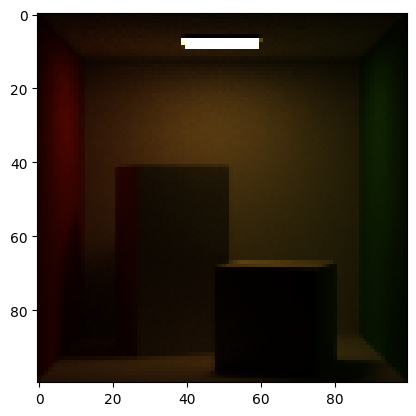

In [18]:
plt.imshow(image_buffer)